# Attention Mechanism Playground

This interactive notebook demonstrates how attention mechanisms work in transformer models. Understanding attention is crucial because it's one of the key innovations that made modern language models possible.

## What is Attention?

Attention mechanisms allow models to focus on different parts of the input sequence when generating each part of the output. Instead of encoding the entire input into a fixed-length vector, attention lets the model learn which input tokens are most relevant for each output token.

## What You'll Learn

- How attention weights connect words in a sequence
- Visualizing attention patterns as heatmaps and connection graphs
- Different types of attention (self-attention, cross-attention)
- Multi-head attention and how it captures different relationships
- How attention enables transformers to handle long-range dependencies


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import math
from transformers import AutoTokenizer, AutoModel, BertModel, BertTokenizer
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import plotly.graph_objects as go
import plotly.express as px
from scipy.special import softmax
import networkx as nx

# Set styling
plt.style.use("ggplot")
sns.set_palette("viridis")
sns.set_context("notebook")

# To prevent warnings
import warnings

warnings.filterwarnings("ignore")

## A Simple Attention Implementation

Let's start by implementing a simple version of the attention mechanism to understand its core principles.

We'll break down attention into its basic components:

1. **Queries (Q)**: What we're looking for
2. **Keys (K)**: What we match against
3. **Values (V)**: What we retrieve

The basic attention formula is: $\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$


In [ ]:
def simple_attention(query, key, value):
    """A simplified implementation of attention mechanism"""
    # Calculate attention scores (dot product of query and key)
    d_k = key.shape[-1]  # dimension of keys
    scores = np.matmul(query, key.transpose()) / math.sqrt(d_k)

    # Apply softmax to get attention weights
    weights = softmax(scores, axis=-1)

    # Apply attention weights to values
    output = np.matmul(weights, value)

    return output, weights


def visualize_attention_weights(tokens, attention_weights, title="Attention Weights"):
    """Visualize attention weights as a heatmap"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        attention_weights,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="viridis",
        annot=True,
        fmt=".2f",
    )
    plt.title(title)
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def visualize_attention_graph(tokens, attention_weights, threshold=0.2):
    """Visualize attention as a directed graph"""
    # Create a graph
    G = nx.DiGraph()

    # Add nodes (tokens)
    for i, token in enumerate(tokens):
        G.add_node(i, label=token)

    # Add edges (attention connections above threshold)
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            weight = attention_weights[i, j]
            if weight > threshold and i != j:  # Skip self-loops if desired
                G.add_edge(i, j, weight=weight, width=weight * 3)

    # Position nodes in a circle
    pos = nx.circular_layout(G)

    # Create plot
    plt.figure(figsize=(12, 10))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue")

    # Draw edges with varying widths based on attention weights
    edges = G.edges(data=True)
    edge_widths = [data["width"] * 3 for _, _, data in edges]
    edge_colors = [plt.cm.viridis(data["weight"]) for _, _, data in edges]
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges,
        width=edge_widths,
        edge_color=edge_colors,
        arrows=True,
        arrowstyle="->",
        arrowsize=20,
        alpha=0.7,
    )

    # Draw labels
    labels = {i: data["label"] for i, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=14, font_weight="bold")

    plt.title("Attention Connections (threshold > {:.2f})".format(threshold))
    plt.axis("off")
    plt.tight_layout()
    plt.show()

## Interactive Toy Example

Let's create a simple example with made-up embeddings to see how attention works.


Token embeddings (random for demonstration):


,0,1,2,3,4,5,6,7
The,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435
cat,-0.469474,0.542560,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288
sat,-1.012831,0.314247,-0.908024,-1.412304,1.465649,-0.225776,0.067528,-1.424748
on,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,-0.601707,1.852278
the,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861
mat,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122
.,0.343618,-1.763040,0.324084,-0.385082,-0.676922,0.611676,1.031000,0.931280


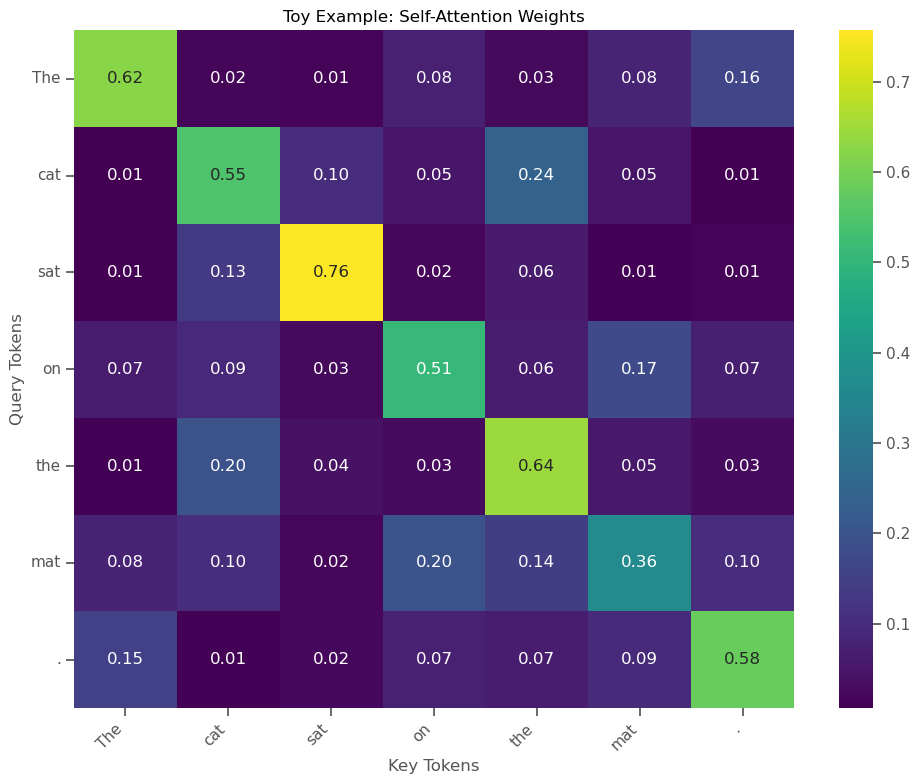

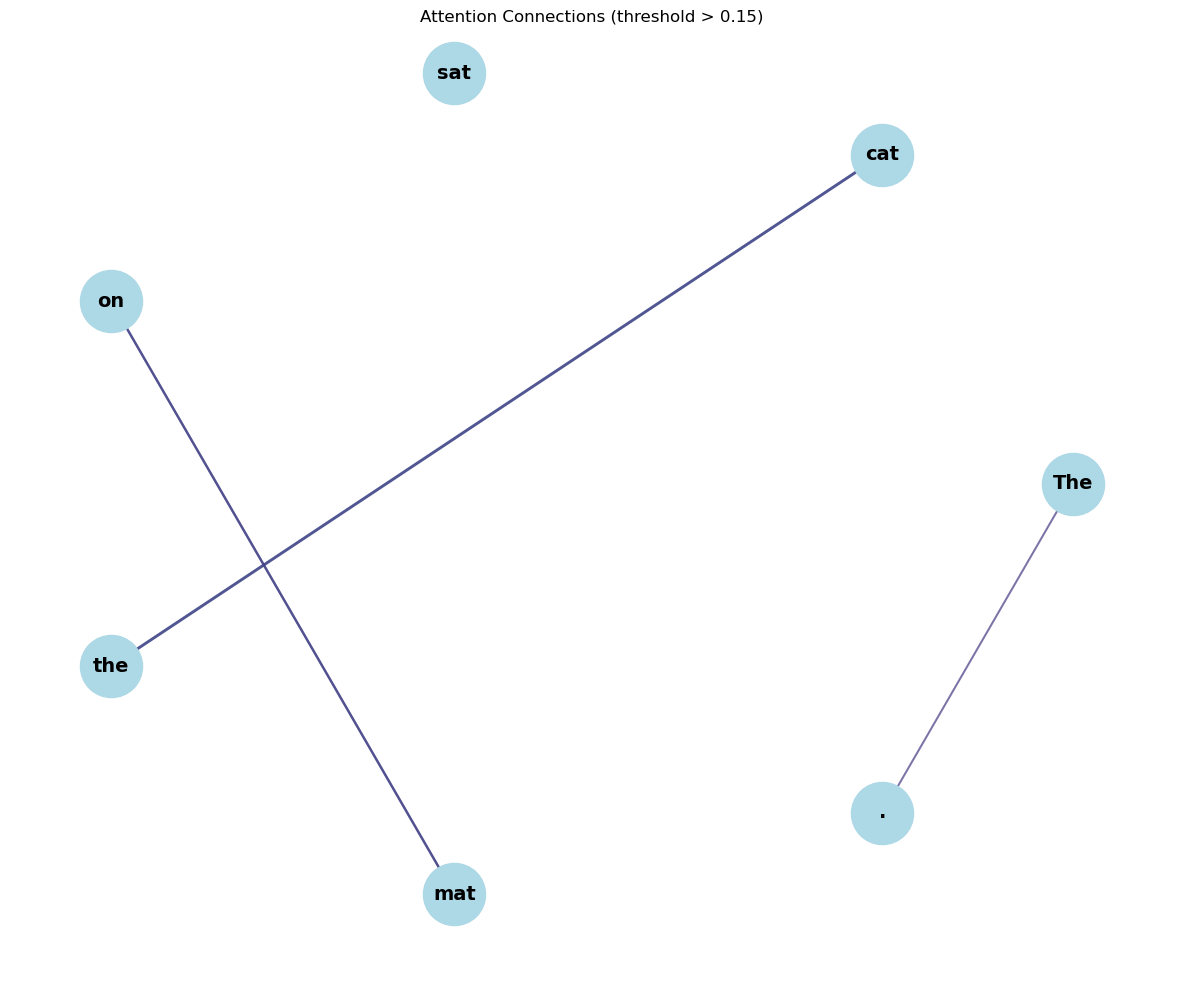

In [3]:
# Define a simple example sentence
tokens = ["The", "cat", "sat", "on", "the", "mat", "."]

# Create toy token embeddings (random for this example)
np.random.seed(42)  # For reproducibility
embedding_dim = 8
token_embeddings = np.random.randn(len(tokens), embedding_dim)

# Display embeddings
print("Token embeddings (random for demonstration):")
display(pd.DataFrame(token_embeddings, index=tokens))

# For this example, we'll use the same embeddings for Q, K, and V
Q = token_embeddings  # Queries
K = token_embeddings  # Keys
V = token_embeddings  # Values

# Apply attention
output, attention_weights = simple_attention(Q, K, V)

# Visualize the attention weights
visualize_attention_weights(tokens, attention_weights, "Toy Example: Self-Attention Weights")

# Visualize as a graph
visualize_attention_graph(tokens, attention_weights, threshold=0.15)

## Multi-Head Attention

In practice, transformers use multiple attention "heads" in parallel. Each head can focus on different aspects of the input.


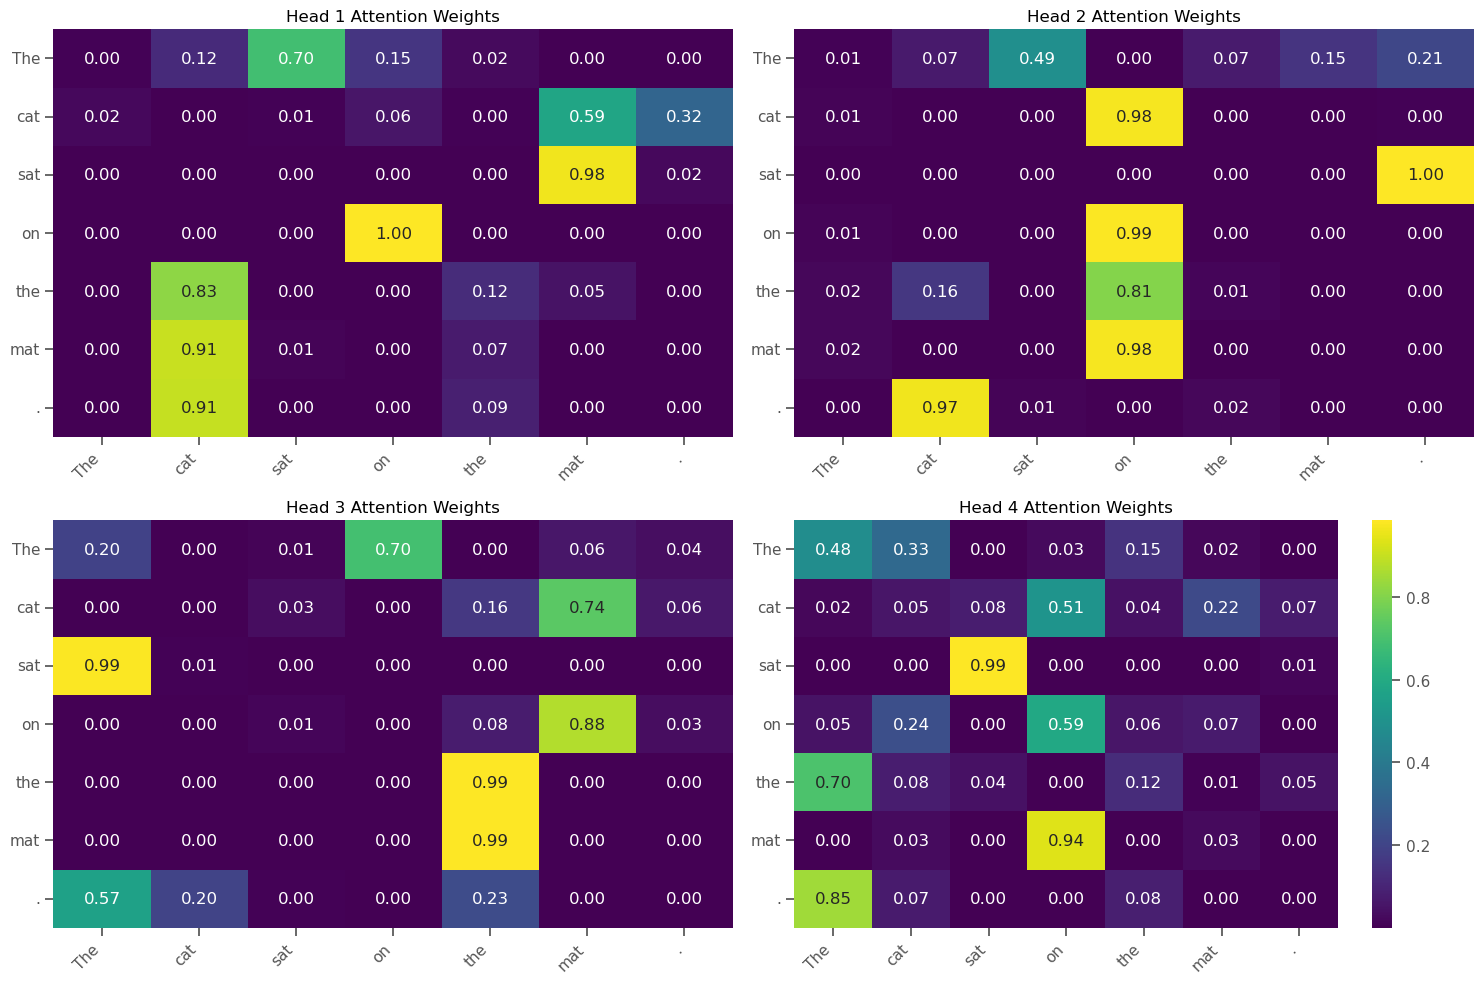

In [ ]:
def multi_head_attention(token_embeddings, num_heads=4, embedding_dim=8):
    """Simplified multi-head attention for demonstration"""
    # For simplicity, we'll generate random projection matrices
    np.random.seed(123)  # For reproducibility
    head_dim = embedding_dim // num_heads

    all_head_outputs = []
    all_head_weights = []

    for h in range(num_heads):
        # Create random projection matrices for this head
        W_q = np.random.randn(embedding_dim, head_dim)
        W_k = np.random.randn(embedding_dim, head_dim)
        W_v = np.random.randn(embedding_dim, head_dim)

        # Project embeddings to get Q, K, V for this head
        Q = np.matmul(token_embeddings, W_q)
        K = np.matmul(token_embeddings, W_k)
        V = np.matmul(token_embeddings, W_v)

        # Apply attention
        head_output, head_weights = simple_attention(Q, K, V)

        all_head_outputs.append(head_output)
        all_head_weights.append(head_weights)

    # Concatenate outputs from all heads
    # In practice, we would project this back to embedding_dim, but we'll skip that

    return all_head_outputs, all_head_weights


# Apply multi-head attention to our toy example
head_outputs, head_weights = multi_head_attention(token_embeddings, num_heads=4)

# Visualize weights from each head
plt.figure(figsize=(15, 10))
for i, weights in enumerate(head_weights):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(
        weights,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="viridis",
        annot=True,
        fmt=".2f",
        cbar=False if i < 3 else True,
    )
    plt.title(f"Head {i+1} Attention Weights")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

## Exploring Real Model Attention

Now let's look at how attention works in a real pre-trained transformer model like BERT.


In [ ]:
# Load pre-trained model and tokenizer
print("Loading BERT model and tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
print("Done!")


def get_bert_attention(text):
    """Get attention weights from BERT for a given text"""
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt")
    token_ids = inputs["input_ids"][0]
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    # Forward pass through model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get attention weights
    # Shape: [batch_size, num_heads, seq_length, seq_length]
    attentions = outputs.attentions

    # Convert to numpy for easier handling
    # We'll take first batch since we only have one example
    attention_weights = [layer_attention[0].numpy() for layer_attention in attentions]

    return tokens, attention_weights


def visualize_bert_attention(tokens, layer_idx, head_idx, attention_weights):
    """Visualize attention for a specific layer and head"""
    # Get attention weights for specified layer and head
    weights = attention_weights[layer_idx][head_idx]

    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(weights, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"BERT Layer {layer_idx+1}, Head {head_idx+1} Attention")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Also visualize as a graph for clearer connections
    visualize_attention_graph(tokens, weights, threshold=0.1)

Loading BERT model and tokenizer...
Done!


## Interactive BERT Attention Visualization

Let's create an interactive tool to explore BERT's attention patterns.


In [ ]:
# Sample texts for exploration
sample_texts = {
    "Simple sentence": "The cat sat on the mat.",
    "Question": "What is the capital of France?",
    "Comparison": "Paris is to France as Rome is to Italy.",
    "Negation": "The movie was not as good as the book.",
    "Coreference": "Although Mary was late, she still managed to catch the train.",
    "Long-range dependency": "The keys, which were on the table in the kitchen, are now missing.",
}

# Create interface widgets
text_dropdown = widgets.Dropdown(
    options=list(sample_texts.keys()),
    value=list(sample_texts.keys())[0],
    description="Example:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="50%"),
)

text_input = widgets.Textarea(
    value=sample_texts[list(sample_texts.keys())[0]],
    placeholder="Enter text to analyze",
    description="Or enter custom text:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="90%", height="100px"),
)

layer_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=11,  # BERT base has 12 layers (0-indexed)
    step=1,
    description="Layer:",
    style={"description_width": "initial"},
)

head_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=11,  # BERT base has 12 attention heads (0-indexed)
    step=1,
    description="Attention Head:",
    style={"description_width": "initial"},
)

threshold_slider = widgets.FloatSlider(
    value=0.1,
    min=0.0,
    max=0.3,
    step=0.01,
    description="Graph Threshold:",
    style={"description_width": "initial"},
)

analyze_button = widgets.Button(
    description="Analyze Attention",
    button_style="primary",
    tooltip="Click to analyze attention patterns",
)

output_area = widgets.Output()


# Update text when example is selected
def update_text(change):
    text_input.value = sample_texts[change["new"]]


text_dropdown.observe(update_text, names="value")


# Define button action
def on_analyze_button_clicked(b):
    with output_area:
        clear_output()
        text = text_input.value
        layer = layer_slider.value
        head = head_slider.value
        threshold = threshold_slider.value

        print(f"Analyzing attention for: '{text}'")
        print(f"Layer: {layer+1}, Head: {head+1}, Graph Threshold: {threshold}")

        # Get attention weights
        tokens, attention_weights = get_bert_attention(text)

        # Visualize attention
        weights = attention_weights[layer][head]

        # Heatmap visualization
        plt.figure(figsize=(12, 10))
        sns.heatmap(weights, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
        plt.title(f"BERT Layer {layer+1}, Head {head+1} Attention")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Graph visualization
        visualize_attention_graph(tokens, weights, threshold=threshold)

        # Also show the average attention across all heads in this layer
        avg_weights = np.mean(attention_weights[layer], axis=0)
        plt.figure(figsize=(12, 10))
        sns.heatmap(avg_weights, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
        plt.title(f"BERT Layer {layer+1}, Average Attention Across All Heads")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()


# Connect button to action
analyze_button.on_click(on_analyze_button_clicked)

# Display interface
display(widgets.HTML("<h2>BERT Attention Visualizer</h2>"))
display(
    widgets.VBox(
        [
            text_dropdown,
            text_input,
            widgets.HBox([layer_slider, head_slider, threshold_slider]),
            analyze_button,
            output_area,
        ]
    )
)

HTML(value='<h2>BERT Attention Visualizer</h2>')

## Attention Patterns Analysis

Let's examine some common attention patterns that appear in transformer models.


In [ ]:
def analyze_attention_patterns(text):
    """Analyze and identify common attention patterns"""
    tokens, attention_weights = get_bert_attention(text)

    # Number of layers and heads
    num_layers = len(attention_weights)
    num_heads = attention_weights[0].shape[0]

    # Calculate statistics for each layer/head
    pattern_stats = []

    for layer in range(num_layers):
        for head in range(num_heads):
            weights = attention_weights[layer][head]

            # Calculate various pattern metrics
            diagonal_attention = np.mean(np.diag(weights))  # Self-attention (diagonal)
            next_token_attention = np.mean(np.diag(weights, k=1))  # Next token attention
            prev_token_attention = np.mean(np.diag(weights, k=-1))  # Previous token attention
            special_tokens_attention = np.mean(weights[:, 0])  # Attention to [CLS] token

            # Identify potential pattern type
            if diagonal_attention > 0.5:
                pattern_type = "Self-attention"
            elif next_token_attention > 0.3:
                pattern_type = "Next-token focus"
            elif prev_token_attention > 0.3:
                pattern_type = "Previous-token focus"
            elif special_tokens_attention > 0.3:
                pattern_type = "Special-token focus"
            else:
                pattern_type = "Mixed attention"

            pattern_stats.append(
                {
                    "Layer": layer + 1,
                    "Head": head + 1,
                    "Pattern": pattern_type,
                    "Self-attention": diagonal_attention,
                    "Next-token": next_token_attention,
                    "Prev-token": prev_token_attention,
                    "[CLS]-token": special_tokens_attention,
                }
            )

    # Create DataFrame
    patterns_df = pd.DataFrame(pattern_stats)

    # Return tokens and patterns
    return tokens, patterns_df, attention_weights


# Create interface
pattern_text = widgets.Textarea(
    value="The quick brown fox jumps over the lazy dog.",
    placeholder="Enter text to analyze attention patterns",
    description="Text:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="90%", height="80px"),
)

pattern_button = widgets.Button(
    description="Analyze Patterns", button_style="info", tooltip="Click to find attention patterns"
)

pattern_output = widgets.Output()


def on_pattern_button_clicked(b):
    with pattern_output:
        clear_output()
        text = pattern_text.value
        print(f"Analyzing attention patterns for: '{text}'")

        tokens, patterns_df, attention_weights = analyze_attention_patterns(text)

        # Display pattern analysis
        display(HTML("<h3>Attention Pattern Analysis</h3>"))
        display(
            patterns_df.style.background_gradient(
                subset=["Self-attention", "Next-token", "Prev-token", "[CLS]-token"], cmap="viridis"
            )
        )

        # Visualize pattern distribution
        plt.figure(figsize=(10, 6))
        pattern_counts = patterns_df["Pattern"].value_counts()
        sns.barplot(x=pattern_counts.index, y=pattern_counts.values)
        plt.title("Distribution of Attention Patterns")
        plt.xlabel("Pattern Type")
        plt.ylabel("Count (Layer-Head Combinations)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Heatmap of attention patterns by layer
        pattern_matrix = np.zeros((num_layers, 5))
        pattern_types = [
            "Self-attention",
            "Next-token focus",
            "Previous-token focus",
            "Special-token focus",
            "Mixed attention",
        ]

        for _, row in patterns_df.iterrows():
            layer = row["Layer"] - 1
            pattern_idx = pattern_types.index(row["Pattern"])
            pattern_matrix[layer, pattern_idx] += 1

        plt.figure(figsize=(12, 8))
        sns.heatmap(
            pattern_matrix,
            annot=True,
            fmt="g",
            cmap="viridis",
            xticklabels=pattern_types,
            yticklabels=[f"Layer {i+1}" for i in range(num_layers)],
        )
        plt.title("Attention Patterns Distribution Across Layers")
        plt.ylabel("Layer")
        plt.xlabel("Pattern Type")
        plt.tight_layout()
        plt.show()


# Connect button
pattern_button.on_click(on_pattern_button_clicked)

# Display interface
display(widgets.HTML("<h2>Attention Pattern Analyzer</h2>"))
display(widgets.VBox([pattern_text, pattern_button, pattern_output]))

HTML(value='<h2>Attention Pattern Analyzer</h2>')

## Attention for Specific NLP Tasks

Different NLP tasks can show different attention patterns. Let's explore some examples.


In [ ]:
task_examples = {
    "Named Entity Recognition": "Apple Inc. was founded by Steve Jobs in Cupertino, California.",
    "Sentiment Analysis": "I absolutely loved the movie, but the ending was disappointing.",
    "Question Answering": "The Eiffel Tower is located in Paris. Where is the Eiffel Tower?",
    "Text Classification": "This email contains information about your recent purchase.",
    "Coreference Resolution": "John told Mary that he would be late for the meeting.",
}

# Create interface
task_dropdown = widgets.Dropdown(
    options=list(task_examples.keys()),
    value=list(task_examples.keys())[0],
    description="Task:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="50%"),
)

task_text = widgets.Textarea(
    value=task_examples[list(task_examples.keys())[0]],
    placeholder="Enter text for specific NLP task",
    description="Text:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="90%", height="80px"),
)

task_button = widgets.Button(
    description="Analyze Task Attention",
    button_style="success",
    tooltip="Click to see attention patterns for this task",
)

task_output = widgets.Output()


# Update text when task is selected
def update_task_text(change):
    task_text.value = task_examples[change["new"]]


task_dropdown.observe(update_task_text, names="value")


def on_task_button_clicked(b):
    with task_output:
        clear_output()
        task = task_dropdown.value
        text = task_text.value
        print(f"Analyzing attention for {task} task: '{text}'")

        tokens, attention_weights = get_bert_attention(text)

        # Show average attention across all layers for each head
        avg_attention_by_head = np.zeros((attention_weights[0].shape[0], len(tokens), len(tokens)))

        for layer in range(len(attention_weights)):
            avg_attention_by_head += attention_weights[layer]

        avg_attention_by_head /= len(attention_weights)

        # Find the most interesting head (highest variance in attention)
        head_variance = np.array(
            [np.var(avg_attention_by_head[i]) for i in range(avg_attention_by_head.shape[0])]
        )
        most_interesting_head = np.argmax(head_variance)

        # Visualize the most interesting head
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            avg_attention_by_head[most_interesting_head],
            xticklabels=tokens,
            yticklabels=tokens,
            cmap="viridis",
        )
        plt.title(f"{task}: Most Informative Attention Head (Head {most_interesting_head+1})")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Show graph for this head
        visualize_attention_graph(
            tokens, avg_attention_by_head[most_interesting_head], threshold=0.1
        )

        # Task-specific interpretation
        print("\nPossible interpretation:")

        if task == "Named Entity Recognition":
            print(
                "→ Look for heads that connect entities to context words or connect multi-word entities."
            )
            print(
                "→ Named entities often have strong attention to themselves and to related words."
            )
        elif task == "Sentiment Analysis":
            print("→ Look for heads that connect sentiment words to the objects they describe.")
            print(
                "→ Notice how attention flows between positive and negative terms, and how 'but' may shift attention."
            )
        elif task == "Question Answering":
            print(
                "→ Look for heads that connect question words (Where, What, etc.) to relevant answer words."
            )
            print("→ Later layers often show strong attention from question words to answer words.")
        elif task == "Text Classification":
            print("→ Look for heads that give high attention to category-indicative words.")
            print(
                "→ The [CLS] token often attends strongly to the most informative words for classification."
            )
        elif task == "Coreference Resolution":
            print(
                "→ Look for heads that connect pronouns (he, she, they) to their potential referents."
            )
            print("→ Some heads specialize in capturing coreference relationships between words.")


# Connect button
task_button.on_click(on_task_button_clicked)

# Display interface
display(widgets.HTML("<h2>Task-Specific Attention Analysis</h2>"))
display(widgets.VBox([task_dropdown, task_text, task_button, task_output]))

HTML(value='<h2>Task-Specific Attention Analysis</h2>')

## Attention Through Layers

Let's visualize how attention evolves through the layers of a transformer model.


In [ ]:
# Create interface
layer_text = widgets.Textarea(
    value="The transformer architecture revolutionized natural language processing.",
    placeholder="Enter text to trace through layers",
    description="Text:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="90%", height="80px"),
)

focus_word = widgets.Text(
    value="transformer",
    placeholder="Enter a word to focus on",
    description="Focus Word:",
    style={"description_width": "initial"},
)

layer_button = widgets.Button(
    description="Trace Through Layers",
    button_style="warning",
    tooltip="Click to see how attention evolves through layers",
)

layer_output = widgets.Output()


def on_layer_button_clicked(b):
    with layer_output:
        clear_output()
        text = layer_text.value
        focus = focus_word.value.lower()
        print(f"Tracing attention through layers for: '{text}'")
        print(f"Focusing on word: '{focus}'")

        tokens, attention_weights = get_bert_attention(text)

        # Find the token(s) that match the focus word
        focus_indices = [i for i, token in enumerate(tokens) if focus in token.lower()]

        if not focus_indices:
            print(f"Word '{focus}' not found in tokenized text. Tokens are: {tokens}")
            return

        focus_idx = focus_indices[0]  # Use the first matching token
        print(f"Focus token: '{tokens[focus_idx]}' at position {focus_idx}")

        # Trace attention from this token through layers
        num_layers = len(attention_weights)

        # Create a figure with a subplot for each layer
        fig, axes = plt.subplots(4, 3, figsize=(18, 14))  # 4x3 grid for 12 layers
        axes = axes.flatten()

        layer_avg_attentions = []

        for layer in range(num_layers):
            # Average across heads for this layer
            layer_avg = np.mean(attention_weights[layer], axis=0)
            layer_avg_attentions.append(layer_avg)

            # Plot attention from focus word to all other words
            attention_from_focus = layer_avg[focus_idx]

            ax = axes[layer]
            bars = ax.bar(range(len(tokens)), attention_from_focus)

            # Highlight the focus word's bar
            bars[focus_idx].set_color("red")

            # Add labels
            ax.set_title(f"Layer {layer+1}")
            ax.set_xticks(range(len(tokens)))
            ax.set_xticklabels(tokens, rotation=90)

            if layer % 3 == 0:  # Left edge
                ax.set_ylabel("Attention Weight")

        plt.tight_layout()
        fig.suptitle(f"Attention from '{tokens[focus_idx]}' Through Layers", fontsize=16, y=1.02)
        plt.show()

        # Create a heatmap showing how attention changes through layers
        layer_attentions = np.array([layer_avg[focus_idx] for layer_avg in layer_avg_attentions])

        plt.figure(figsize=(12, 8))
        sns.heatmap(
            layer_attentions,
            xticklabels=tokens,
            yticklabels=[f"Layer {i+1}" for i in range(num_layers)],
            cmap="viridis",
        )
        plt.title(f"Attention from '{tokens[focus_idx]}' Across Layers")
        plt.xlabel("Tokens")
        plt.ylabel("Layer")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        # Create an animation of attention graphs through layers
        print("\nEvolution of attention through layers:")
        for layer in [0, 3, 7, 11]:  # Show a selection of layers
            print(f"\nLayer {layer+1} attention from '{tokens[focus_idx]}':")
            # Create single-source attention graph
            G = nx.DiGraph()

            # Add nodes
            for i, token in enumerate(tokens):
                G.add_node(i, label=token)

            # Add edges from focus word to others
            threshold = 0.1
            for i, weight in enumerate(layer_avg_attentions[layer][focus_idx]):
                if weight > threshold and i != focus_idx:
                    G.add_edge(focus_idx, i, weight=weight, width=weight * 3)

            # Position nodes in a circle
            pos = nx.circular_layout(G)

            # Create plot
            plt.figure(figsize=(10, 8))

            # Draw nodes
            node_colors = ["red" if n == focus_idx else "lightblue" for n in G.nodes()]
            nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors)

            # Draw edges
            edges = G.edges(data=True)
            if edges:
                edge_widths = [data["width"] * 3 for _, _, data in edges]
                edge_colors = [plt.cm.viridis(data["weight"]) for _, _, data in edges]
                nx.draw_networkx_edges(
                    G,
                    pos,
                    edgelist=edges,
                    width=edge_widths,
                    edge_color=edge_colors,
                    arrows=True,
                    arrowstyle="->",
                    arrowsize=20,
                    alpha=0.7,
                )

            # Draw labels
            labels = {i: data["label"] for i, data in G.nodes(data=True)}
            nx.draw_networkx_labels(G, pos, labels, font_size=14, font_weight="bold")

            plt.title(f"Layer {layer+1}: Attention from '{tokens[focus_idx]}'")
            plt.axis("off")
            plt.tight_layout()
            plt.show()


# Connect button
layer_button.on_click(on_layer_button_clicked)

# Display interface
display(widgets.HTML("<h2>Layer-by-Layer Attention Tracer</h2>"))
display(widgets.VBox([layer_text, focus_word, layer_button, layer_output]))

HTML(value='<h2>Layer-by-Layer Attention Tracer</h2>')

## Key Takeaways

1. **Attention mechanisms** allow models to focus on different parts of the input when generating each part of the output.

2. **Self-attention** is the core operation in transformer models that allows each token to attend to all other tokens in the sequence.

3. **Multi-head attention** enables models to focus on different relationships simultaneously:

   - Some heads track syntactic relationships
   - Others focus on semantic relationships
   - Some specialize in specific linguistic phenomena (e.g., coreference)

4. **Attention patterns** evolve through the layers of a transformer:

   - Early layers often capture local, syntactic information
   - Middle layers mix information broadly
   - Later layers often capture task-specific, semantic relationships

5. **Different NLP tasks** show distinctive attention patterns that reveal how the model processes information for that task.

6. **Understanding attention** can help us interpret model behavior, improve model architecture, and design better prompts.


## Further Reading

- [Attention Is All You Need](https://arxiv.org/abs/1706.03762) - The original transformer paper
- [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) - Visual explanation of transformers
- [BertViz](https://github.com/jessevig/bertviz) - Tool for visualizing attention in transformer models
- [A Survey of Methods for Interpreting and Visualizing Attention in NLP](https://arxiv.org/abs/2104.07320)
- [Transformer Interpretability Beyond Attention Visualization](https://arxiv.org/abs/2012.09838)
